Connect to Neo4j instance using the [Py2neo Python Library v2](http://py2neo.org/2.0/)

In [1]:
from py2neo import Graph, authenticate

authenticate("192.168.99.100:7474", "neo4j", "itsyoubob")
graph = Graph("http://192.168.99.100:7474/db/data/")

Use a Cypher query find the tweet date range and print the results.

In [2]:
query = """
MATCH (t:Tweet)
WHERE HAS (t.created_at)
RETURN MIN(t.created_at), MAX(t.created_at)
"""

date_range = graph.cypher.execute(query)

print date_range

   | MIN(t.created_at)              | MAX(t.created_at)             
---+--------------------------------+--------------------------------
 1 | Wed Sep 09 04:13:06 +0000 2015 | Wed Sep 09 04:39:07 +0000 2015



Find the top 25 hashtags and import the results into a [Pandas](http://pandas.pydata.org/) DataFrame.

In [3]:
import pandas 

query = """
MATCH (h:Hashtag)-[:TAGS]->(t:Tweet)         
RETURN h.name AS hashtag, COUNT(t) AS tweets 
ORDER BY tweets DESC LIMIT 25
"""

top_hashtags = graph.cypher.execute(query)

top_hashtags_df = pandas.DataFrame(top_hashtags.records, columns=top_hashtags.columns)
top_hashtags_df

,hashtag,tweets
0,lateshow,955
1,health,735
2,lssc,515
3,colbert,275
4,tcot,193
5,jebbush,175
6,news,175
7,jeb,126
8,kimdavis,123
9,trump,122


Use matplotlib to plot the top 25 hashtags as a bar graph.

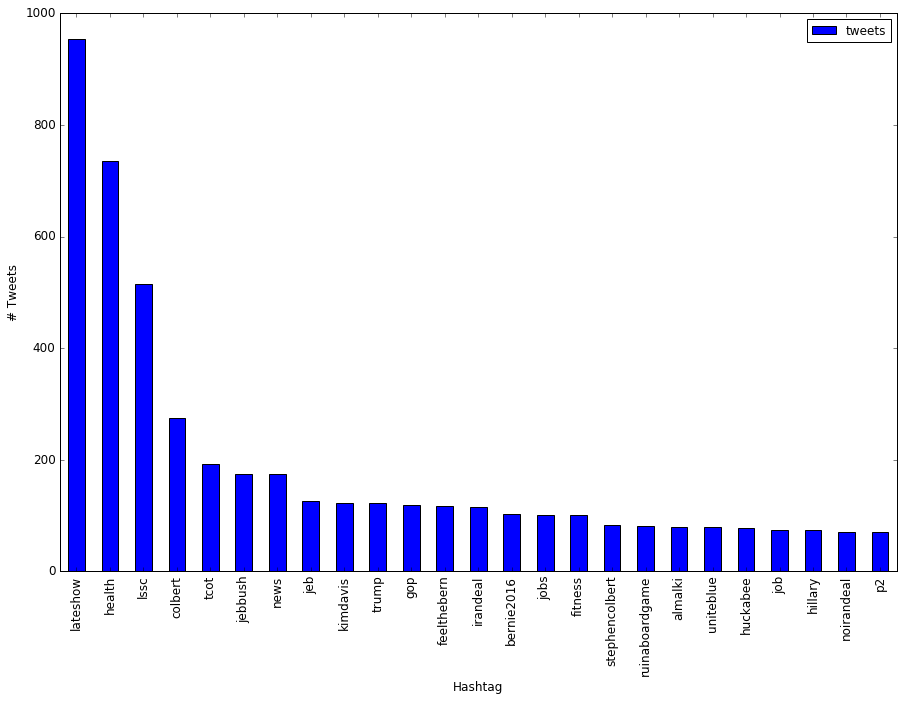

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
ax = top_hashtags_df.plot(kind='bar', figsize=(15,10), legend=True, fontsize=12)
ax.set_xticklabels(top_hashtags_df["hashtag"])
ax.set_xlabel("Hashtag", fontsize=12)
ax.set_ylabel("# Tweets", fontsize=12)
plt.show()